In [1]:
%matplotlib notebook
%load_ext autoreload
%pwd

'/ocean/projects/asc170022p/mtragoza/lung-project/notebooks'

In [2]:
%time
import sys, os
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/pkgconfig'

sys.path.append('..')
import project

CPU times: user 1 μs, sys: 1 μs, total: 2 μs
Wall time: 4.77 μs


In [3]:
# configuration settings
data_root = '../data/phantom_lung_1000'
mesh_radius = 10
interp_radius = 10
interp_sigma = 5
num_levels = 3
num_conv_layers = 2
conv_channels = 4
conv_kernel_size = 3
output_func = 'relu'
batch_size = 2
learning_rate = 1e-5

save_every = 10
save_prefix = '2024-10-26__lung'
#save_prefix = f'2024-09-30__initial/train__batch_size__{mesh_radius}__{interp_radius}__{interp_sigma}__{output_func}__{batch_size}/'
load_epoch = 0

Loading ../data/phantom_lung_1000/phantom5/phantom5_anat.nii.gz
Loading ../data/phantom_lung_1000/phantom5/phantom5_elast.nii.gz
Loading ../data/phantom_lung_1000/phantom5/phantom5_disp.nii.gz
Loading ../data/phantom_lung_1000/phantom5/phantom5_mask.nii.gz
CT


<IPython.core.display.Javascript object>


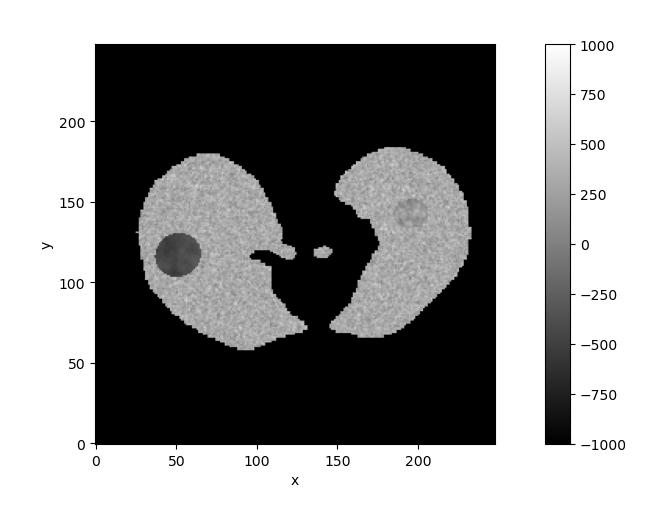

interactive(children=(SelectionSlider(description='z', options=((0.0, 0), (2.5, 1), (5.0, 2), (7.5, 3), (10.0,…

elasticity


<IPython.core.display.Javascript object>


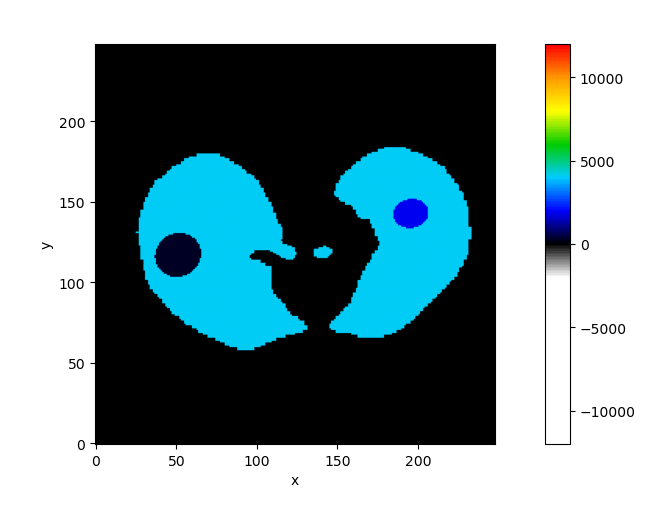

interactive(children=(SelectionSlider(description='z', options=((0.0, 0), (2.5, 1), (5.0, 2), (7.5, 3), (10.0,…

displacement


<IPython.core.display.Javascript object>


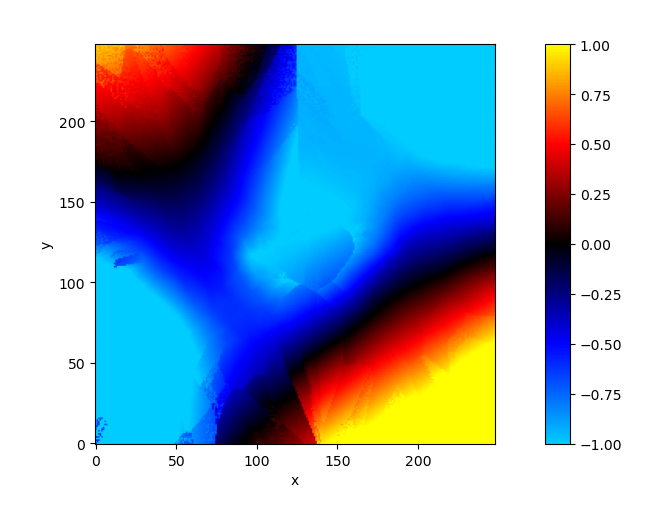

interactive(children=(SelectionSlider(description='z', options=((0.0, 0), (2.5, 1), (5.0, 2), (7.5, 3), (10.0,…

Loading ../data/phantom_lung_1000/phantom5/phantom5_mesh10.xdmf
Loading ../data/phantom_lung_1000/phantom5/phantom5_mesh10.xdmf... 5070


In [13]:
%autoreload
phantom_set = project.phantom.PhantomSet(data_root, num_phantoms=100)
phantom = phantom_set[5]
phantom.load_niftis()
project.visual.XArrayViewer(phantom.anat)
project.visual.XArrayViewer(phantom.elast)
project.visual.XArrayViewer(phantom.disp)
phantom.load_mesh(10)
phantom.mesh

In [14]:
all_examples = phantom_set.get_examples(mesh_radius)
train_examples = all_examples[10:]
test_examples = all_examples[:10]
len(train_examples), len(test_examples)

(90, 10)

In [15]:
all_examples[0]

{'name': 'phantom0',
 'anat_file': PosixPath('../data/phantom_lung_1000/phantom0/phantom0_anat.nii.gz'),
 'elast_file': PosixPath('../data/phantom_lung_1000/phantom0/phantom0_elast.nii.gz'),
 'disp_file': PosixPath('../data/phantom_lung_1000/phantom0/phantom0_disp.nii.gz'),
 'mask_file': PosixPath('../data/phantom_lung_1000/phantom0/phantom0_mask.nii.gz'),
 'mesh_file': PosixPath('../data/phantom_lung_1000/phantom0/phantom0_mesh10.xdmf'),
 'mesh_radius': 10}

In [16]:
train_data = project.data.Dataset(train_examples)
test_data = project.data.Dataset(test_examples)

In [17]:
model = project.model.UNet3D(
    in_channels=1,
    out_channels=1,
    num_levels=num_levels,
    num_conv_layers=num_conv_layers,
    conv_channels=conv_channels,
    conv_kernel_size=conv_kernel_size,
).cuda()

In [18]:
%autoreload
trainer = project.training.Trainer(
    model=model,
    train_data=train_data,
    test_data=test_data,
    batch_size=batch_size,
    learning_rate=learning_rate,
    interp_radius=interp_radius,
    interp_sigma=interp_sigma,
    save_every=save_every,
    save_prefix=save_prefix,
    sync_cuda=True
)

In [19]:
if load_epoch:
    trainer.load_state(epoch=load_epoch)

Loading ../data/phantom_lung_1000/phantom0/phantom0_anat.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung_1000/phantom0/phantom0_disp.nii.gz... (256, 256, 94, 3)
Loading ../data/phantom_lung_1000/phantom0/phantom0_mask.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung_1000/phantom0/phantom0_mesh10.xdmf... 5064
Loading ../data/phantom_lung_1000/phantom0/phantom0_elast.nii.gz... (256, 256, 94)
['phantom0'].

<IPython.core.display.Javascript object>


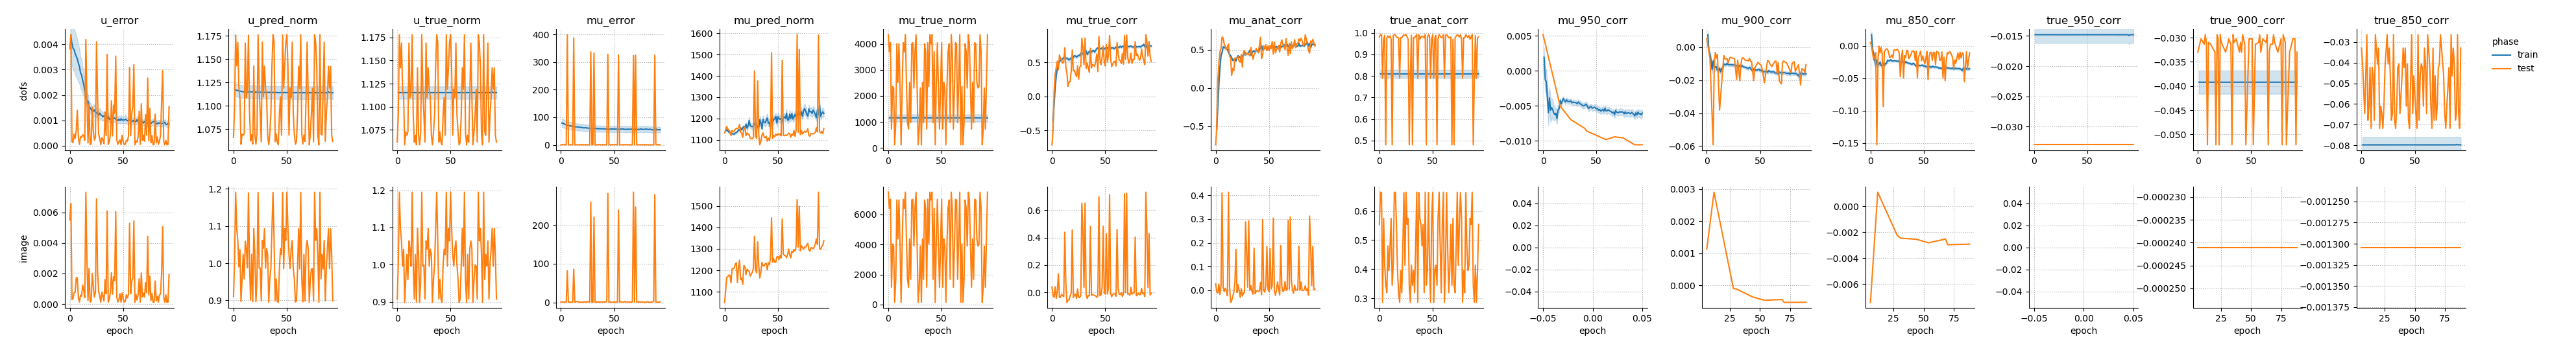

anat


<IPython.core.display.Javascript object>


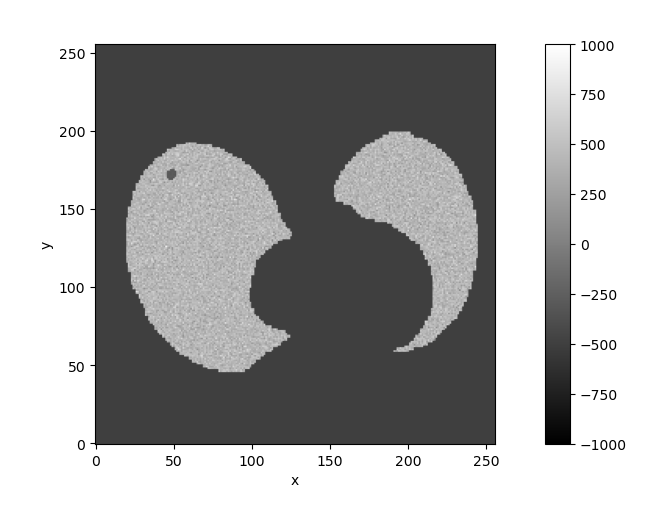

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

emph


<IPython.core.display.Javascript object>


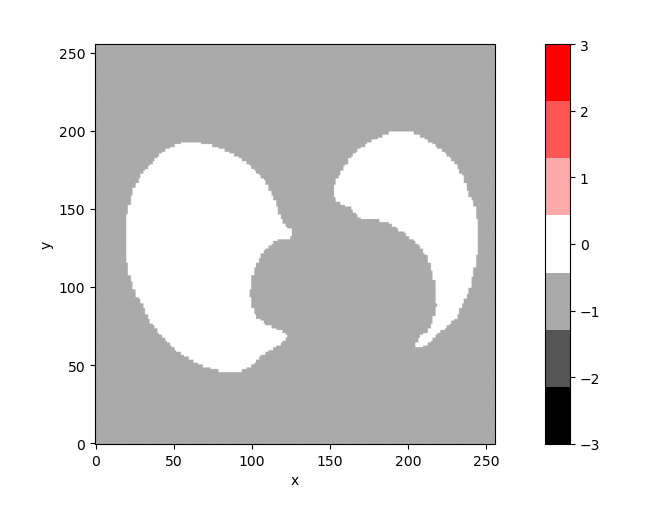

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

mu_pred


<IPython.core.display.Javascript object>


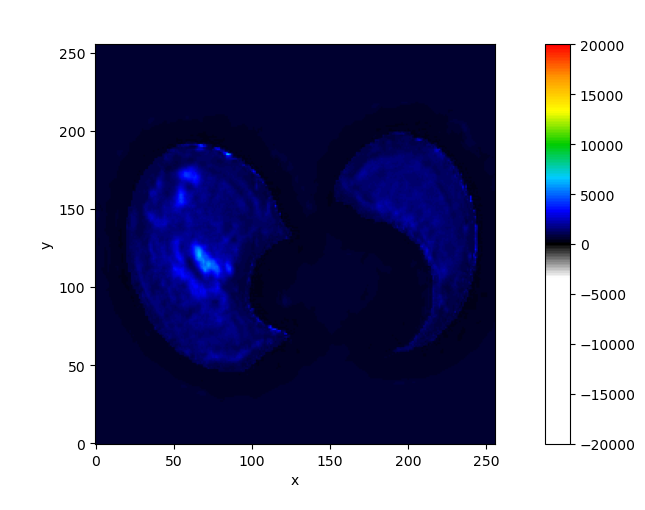

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

mu_true


<IPython.core.display.Javascript object>


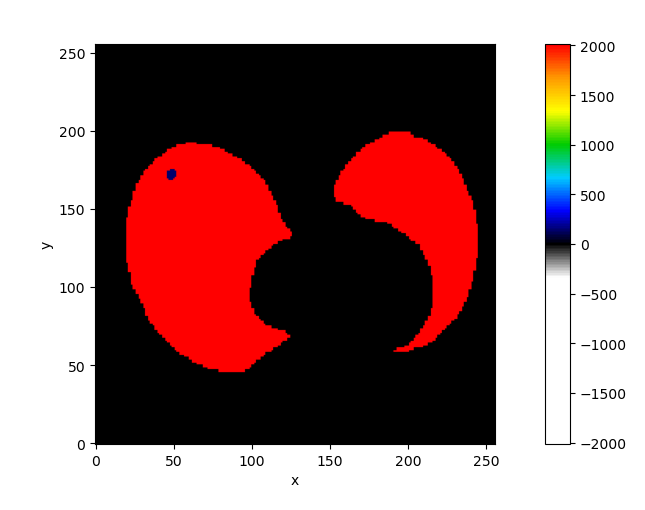

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

u_pred


<IPython.core.display.Javascript object>


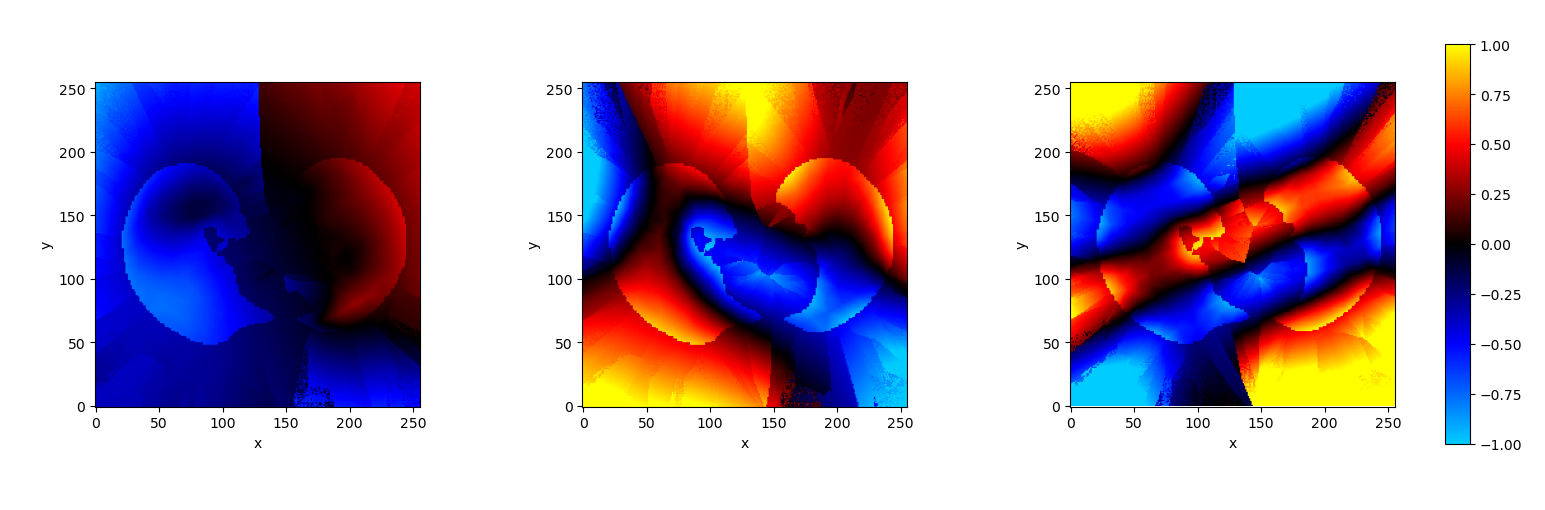

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

u_true


<IPython.core.display.Javascript object>


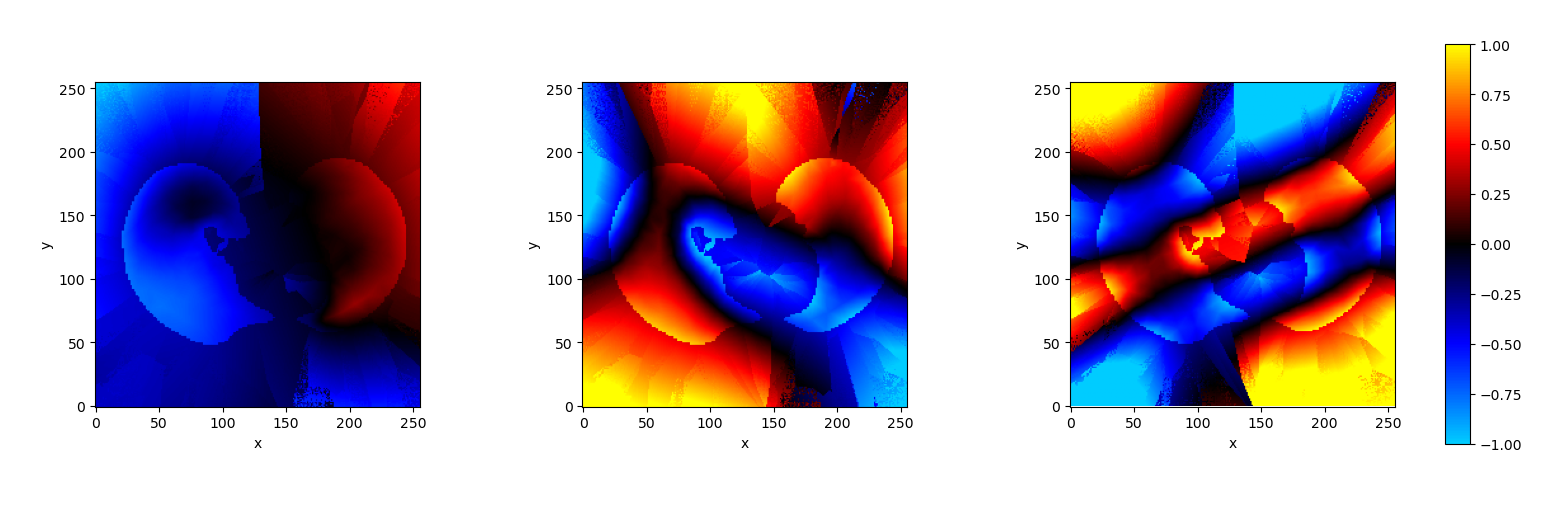

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

0.0038
CPU times: user 2min 32s, sys: 1.12 s, total: 2min 33s
Wall time: 2min 37s


In [20]:
%%time
# test forward pass and initialize viewers
trainer.timer.start()
trainer.run_next_batch(phase='test', epoch=0)

In [21]:
trainer.save_metrics()
trainer.save_viewers()
trainer.save_state()

In [23]:
%%time
trainer.timer.start()
trainer.train(num_epochs=100)

Training...
Epoch 89/188
Running train phase
['phantom75', 'phantom67']..0.0004
['phantom36', 'phantom68']..0.0006
['phantom59', 'phantom48']..0.0003
['phantom10', 'phantom47']..0.0010
['phantom16', 'phantom53']..0.0008
['phantom2'].0.0000
Epoch 90/188
Running train phase
['phantom35', 'phantom77']..0.0005
['phantom27', 'phantom23']..0.0001
['phantom89', 'phantom13']..0.0023
['phantom25', 'phantom26']..0.0003
['phantom11', 'phantom12']..0.0015
['phantom67', 'phantom45']..0.0006
['phantom46', 'phantom30']..0.0004
['phantom87', 'phantom69']..0.0003
['phantom65', 'phantom33']..0.0010
['phantom60', 'phantom10']..0.0012
['phantom90', 'phantom16']..0.0007
['phantom86', 'phantom41']..0.0015
['phantom98', 'phantom17']..0.0012
['phantom73', 'phantom94']..0.0015
['phantom31', 'phantom82']..0.0006
['phantom49', 'phantom19']..0.0012
['phantom54', 'phantom80']..0.0027
['phantom22', 'phantom51']..0.0007
['phantom74', 'phantom63']..0.0002
['phantom36', 'phantom14']..0.0006
['phantom57', 'phantom18'].


KeyboardInterrupt



In [ ]:
trainer.evaluator.metrics

In [ ]:
trainer.timer.usage

In [ ]:
trainer.timer.usage.groupby(['phase', 'event']).mean().sort_values('time')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(trainer.timer.usage, y='event', x='time', hue='phase', estimator='mean', ax=ax)
ax.set_xlabel('time (s)')
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(trainer.timer.usage , y='event', x='time', hue='phase', estimator='sum', ax=ax)
#ax.set_xscale('log')
ax.set_xlabel('time (s)')
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(4,4))
sns.barplot(trainer.timer.usage, y='time', x='phase', estimator='mean', ax=ax)
ax.set_ylabel('time (s)')
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(4,4))
sns.barplot(trainer.timer.usage, y='time', x='phase', estimator='sum', ax=ax)
ax.set_ylabel('time (s)')
fig.tight_layout()

In [ ]:
test_data[0][-5].mean()